# Cooperative Learning

## Intro

The Tennis game is solved here with a method loosely following multi-agent deep deterministic policy gradients. (https://arxiv.org/abs/1706.02275v3) 

## Multi-agent Deep Deterministic Policy Gradients Overview

This method is an actor-critic method with a deterministic policy (the actor) that outputs an action for an agent in a certain state. The main difference from the normal deep deterministic policy method is that the critic used in training is input the states and actions of all agents, and then provides an estimate of the action-value function for each agent.

In the most general setting there are individual actor and critic networks for each agent and parameters are learned separately for each agent. In the case of the tennis game however, the agents are completely symmetrical, hence learning for one helps the other just as much. So in this solution there is a single actor and a single critic and they act for both agents. This is done by reversing the agent experiences and adding these mirrored experiences to the batch used for training. (See `Agent.learn` in the `agent.py` file.) 

The critic is trained by minimising the 1-step bootstrapping Bellman equation error. The error is measured with respect to a target network.

## Solution
 
### Neural networks

The general structure of the networks are the same as the original DDPG paper, modified with additional inputs for multiple agents. Noise added to the output of the actor from a random walk to aid exploration.

Actor network:
 1. 24 inputs, i.e., 12 each for 2 agents.
 2. 400 hidden units, no bias, batch normalisation, ELU
 3. Dropout
 4. 300 hidden units, no bias, batch normalisation, ELU
 5. 4 outputs, no bias, batch normalisation, tanh activation
 
State network (submodule of the critic):
 1. 24 inputs
 2. 400 outputs
 3. Dropout
 
Critic network:
 1. 4 action inputs (2x2 agents) + 400 outputs from state network, ELU
 2. 300 hidden units, ELU
 3. 1 output

### Training

I used a dropout layer (p=0.2) after the first hidden layer of each network, (the original DDPG uses L2 regularisation.)

I used ADAM optimiser as per the paper. Learning rates for the critic and actor are 1e-3 and 1e-4 respectively.

Mini-batches of 64 samples are taken from the replay buffer every step of the episode for training. After swapping the agents this doubles to 128.

The actor output noise was reduced each episode at a rate of 0.9995, starting from 0.2.


### Implementation

 * `actor.py`: The actor network
 * `critic.py`: The critic newtork
 * `agent.py`: The agent, including the policy evaulation and learning steps
 * `replay_buffer.py`: Implementation of the replay buffer with priority.


## Conclusion

A reasonable multi-agent learning performance can be achieved with only simple modifications to the DDPG method.

In fact this enviroment can be solved without these modifications: using a critic that only sees a single agent solves this environment too.

## Further Work

This method is limited to this kind of symmetric game where the strategies learned are applicable to all agents.

To solve a more complex environment such as the Soccer env, the agents must be separated so that can learn their own specialised role, (i.e., striker, goal keeper.) 

The performance of the critic is also limited in this setting. For each agent we add more inputs to the critic network, but rest of the network does not grow to accomodate, so the final estimation may end up biased. Expanding the size of the rest of the network may be necessary with more agents.

Unlike actual tennis, this environment is cooperative. The score is related to simply getting the ball over the net, rather that forcing the opponent to make an error. Making this competitive by using a different score would be an interesting next step.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML
from unityagents import UnityEnvironment

from unity_env import unity_episode, get_agent_requirements, wrap_env
from train import train
from agent import default_agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env_path = 'Tennis_Linux_NoVis/Tennis.x86_64'
env = UnityEnvironment(file_name=env_path)

brain_name, state_size, action_size = get_agent_requirements(env)

episode_fn = wrap_env(env, brain_name)

agent = default_agent(device, state_size, action_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
scores = train(episode_fn, agent, max_eps=int(2e5), min_score=1.0)

ep =       100, total steps =      1626, score =  0.01, best =  0.01 *
ep =       200, total steps =      3172, score =  0.01, best =  0.01  
ep =       300, total steps =      4773, score =  0.01, best =  0.01  
ep =       400, total steps =      6353, score =  0.01, best =  0.01 *
ep =       500, total steps =      7920, score =  0.01, best =  0.01  
ep =       600, total steps =      9562, score =  0.01, best =  0.01 *
ep =       700, total steps =     10985, score =  0.00, best =  0.01  
ep =       800, total steps =     12412, score =  0.00, best =  0.01  
ep =       900, total steps =     14180, score =  0.02, best =  0.02 *
ep =      1000, total steps =     15667, score =  0.00, best =  0.02  
ep =      1100, total steps =     17836, score =  0.03, best =  0.03 *
ep =      1200, total steps =     20849, score =  0.05, best =  0.05 *
ep =      1300, total steps =     29240, score =  0.20, best =  0.20 *
ep =      1400, total steps =     37465, score =  0.21, best =  0.21 *
ep =  

Plot of scores, and mean scores over 100 episodes:

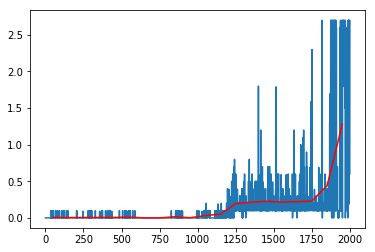

In [4]:
avg_scores = np.array(scores).reshape(-1, 100).mean(axis=1)
plt.plot(scores)
plt.plot(np.arange(avg_scores.shape[0]) * 100 + 50, avg_scores, 'r-')

In [5]:
agent.restore('best')
agent.noise.sigma = 0.0

steps, score = unity_episode(env, agent, env.brain_names[0], train=False)
steps, score

(1001, 2.600000038743019)

In [6]:
%%HTML
<video width="320" height="240" controls>
  <source src="./recording.mp4" type="video/mp4">
</video>